In [29]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

from data_analysis_helper_fun import *

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

## Loading Data

In [32]:
 # relative path to data directory
data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
data_set_name = 're_data_tau_alpha_mini'
data_file_name = f'{data_set_name}.csv.tar.gz'
re_data = load_re_data(data_dir, 
                                data_file_name,
                                usecols = ["model_name",
                                           'n_sentence_pool',
                                           "ds",
                                           "init_coms",
                                           'weight_account', 
                                           'weight_systematicity',
                                           "n_fixed_points",
                                           'fp_account', 
                                           'fp_faithfulness',
                                           "n_global_optima",
                                           'go_account', 
                                           'go_faithfulness',
                                           'error_code',
                                           'fixed_points',
                                           'global_optima'
                                           ],
                               evalcols = [
                                    'fp_account', 
                                   'fp_faithfulness',
                                   'go_account', 
                                    'go_faithfulness',
                                   'fixed_points',
                                    'global_optima'
                                   ],
                      filter_erroneous_runs = True)

In [33]:
# useful, if filter_erroneous_runs = False

print(f"The data set contains {sum(re_data['error_code'].isna()==False)}/{len(re_data)} rows of erroneous model runs.")
# filter
re_data = re_data.loc[re_data['error_code'].isna()]

The data set contains 0/349319 rows of erroneous model runs.


In [34]:
# output directory
tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

In [35]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())
print('\n')

General information: 
   Amount of rows: 349319
   Number of dialectical structures: 20
   Overall number of initial commitments: 80
   Sentence-pools: [6 7 8 9]
   Models: ['QuadraticGlobalRE' 'LinearGlobalRE' 'QuadraticLocalRE' 'LinearLocalRE']




In [36]:
re_data.columns

Index(['model_name', 'ds', 'n_sentence_pool', 'weight_account',
       'weight_systematicity', 'init_coms', 'error_code', 'fixed_points',
       'n_fixed_points', 'fp_account', 'fp_faithfulness', 'global_optima',
       'n_global_optima', 'go_account', 'go_faithfulness', 'model_short_name'],
      dtype='object')

## Setup Dataframes

In [53]:
""" 
If `analyse_branches` is set to `true`, all branches of RE processes are considered for the analysis. 
This may lead to the multiple counting of a unique fixed point, 
if they are reached on different paths from a simulation setup.
Otherwise, the subsequent analysis comprises only unique fixed points per simulation setups
"""

# Currently, no information concerning account/faithfulness values is stored in branches.
analyse_branches = False 


grouping = ["model_name"]

# Whether resulting tables and figures are exported to the corresponing output directory"""
export_results = True

In [54]:
# the analysis of global optima is not affected by status of `analyse_branches`

# restrict data to unique simulation setups to prevent multiple counting of branches 
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                         "ds",
                         "n_sentence_pool",
                         'weight_account', 
                         'weight_systematicity', 
                         'init_coms'
                        ])

# restrict to relevant columns
go_data = re_data_unique_setups[["model_name",
                                 "ds",
                                 "init_coms",
                                 "weight_account", 
                                 "weight_systematicity",
                                 "global_optima",
                                 'go_account', 
                                 'go_faithfulness'
                                ]]

# explode information about global optima, which is stored rowwise (per simulation setup) 
# in lists (e.g. in the column `go_full_re_state`)
exploded_go_data = go_data.set_index(["model_name",
                                      "ds",
                                      "init_coms",
                                      "weight_account", 
                                      "weight_systematicity",
                                     ]).apply(pd.Series.explode).reset_index()

exploded_go_data.shape

(247843, 8)

In [55]:
# add lengths of global optima theories
exploded_go_data["go_theory_len"] = exploded_go_data["global_optima"].apply(lambda x: len(x[0]))

In [56]:
re_data_unique_setups.groupby("model_name")["ds"].size()

model_name
LinearGlobalRE       14400
LinearLocalRE        14330
QuadraticGlobalRE    14399
QuadraticLocalRE     14384
Name: ds, dtype: int64

In [57]:
if analyse_branches:
    
    raise ValueError("`analyse_branches` cannot be set to `true`")
    # use all rows and restrict to relevant columns
    #fp_data = re_data[["model_name",
    #                   "ds",
    #                   "init_coms",
    #                   "weight_account", 
    #                   "weight_systematicity", 
    #                   'fixed_point_is_full_re_state']]
    #
    ## rename fixed point columns 
    ## note: df is already exploded
    #exploded_fp_data = fp_data.rename(columns={'fixed_point_is_full_re_state': "fp_full_re_state",})
    
else:
    
    # use unique setups and restrict to relevant columns
    fp_data = re_data_unique_setups[["model_name",
                                     "ds",
                                     "init_coms",
                                     "weight_account", 
                                     "weight_systematicity",
                                     "fixed_points",
                                     'fp_account', 
                                     'fp_faithfulness',
                                    ]]
    
    # explode information about unique fixed points, which is stored rowwise (per simulation setup) 
    # in lists (e.g. in the column `fp_full_re_state`) 
    exploded_fp_data = fp_data.set_index(["model_name",
                                          "ds",
                                          "init_coms",
                                          "weight_account", 
                                          "weight_systematicity"]).apply(pd.Series.explode).reset_index()
    
exploded_fp_data.shape

(152485, 8)

In [58]:
# add lengths of fixed points theories
exploded_fp_data["fp_theory_len"] = exploded_fp_data["fixed_points"].apply(lambda x: len(x[0]))

In [59]:
#for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
#
#    fig = make_subplots(rows=2, cols=2,
#                        shared_xaxes=True,
#                        #shared_yaxes=True,
#                        vertical_spacing=0.12,
#                        subplot_titles=(model_names))
#
#    for model_name, pos in zip(model_names, [(1,1), (1,2), (2,1), (2,2)]):
#
#        g_df = df[df["model_name"]==model_name]
#
#        # Note: init_coms is used as a dummy column for counting
#        g_df = g_df.groupby("{}_account".format(endpoint_type))["init_coms"].size().reset_index()
#
#        fig.add_trace(go.Bar(x=g_df["{}_account".format(endpoint_type)], 
#                             y=g_df["init_coms"],
#                             marker_color=viridis_map[model_name]), 
#                      row=pos[0], 
#                      col=pos[1])
#
#    fig.update_xaxes(title_text="Account", row=2, col=1)
#    fig.update_xaxes(title_text="Account", row=2, col=2)
#    
#    fig.update_xaxes(range=[0.0, 1.0])
#
#    fig.update_yaxes(title_text="Number", row=1, col=1)
#    fig.update_yaxes(title_text="Number", row=2, col=1)
#
#    fig.update_annotations(font_size=12)
#    fig.update_yaxes(title_font=dict(size=12))
#    fig.update_xaxes(title_font=dict(size=12))
#    
#    endpoint = "global optima" if endpoint_type == "go" else "fixed points"
#    fig_title = "Number of {} achieving specific account measure values".format(endpoint)
#    
#    fig.update_layout(template="plotly_white",
#                      showlegend=False,
#                      title=fig_title)
#
#    fig.show()

In [60]:
#for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
#
#    fig = make_subplots(rows=2, cols=2,
#                        shared_xaxes=True,
#                        #shared_yaxes=True,
#                        vertical_spacing=0.12,
#                        subplot_titles=(model_names))
#
#    for model_name, pos in zip(model_names, [(1,1), (1,2), (2,1), (2,2)]):
#
#        g_df = df[df["model_name"]==model_name]
#
#        # Note: init_coms is used as a dummy column for counting
#        g_df = g_df.groupby("{}_faithfulness".format(endpoint_type))["init_coms"].size().reset_index()
#
#        fig.add_trace(go.Bar(x=g_df["{}_faithfulness".format(endpoint_type)], 
#                             y=g_df["init_coms"],
#                             marker_color=viridis_map[model_name]), 
#                      row=pos[0], 
#                      col=pos[1])
#
#    fig.update_xaxes(title_text="Faithfulness", row=2, col=1)
#    fig.update_xaxes(title_text="Faithfulness", row=2, col=2)
#    
#    fig.update_xaxes(range=[0.0, 1.0])
#
#    fig.update_yaxes(title_text="Number", row=1, col=1)
#    fig.update_yaxes(title_text="Number", row=2, col=1)
#
#    fig.update_annotations(font_size=12)
#    fig.update_yaxes(title_font=dict(size=12))
#    fig.update_xaxes(title_font=dict(size=12))
#    
#    endpoint = "global optima" if endpoint_type == "go" else "fixed points"
#    fig_title = "Number of {} achieving specific faithfulness measure values".format(endpoint)
#    
#    fig.update_layout(template="plotly_white",
#                      showlegend=False,
#                      title=fig_title)
#
#    fig.show()

## Tables

### Maximal values

In [61]:
grouping = ["model_name"]

In [62]:
# number of global optima with account = 1
df1 = exploded_go_data[exploded_go_data["go_account"]==1].groupby(grouping)["go_account"].size().reset_index()
df1.rename(columns={"go_account":"n_go_max_account"}, inplace=True)

# number of global optima with systematicity = 1
df2 = exploded_go_data[exploded_go_data["go_theory_len"]==1].groupby(grouping)["go_theory_len"].size().reset_index()
df2.rename(columns={"go_theory_len":"n_go_max_systematicity"}, inplace=True)

# number of global optima with faithfulness = 1
df3 = exploded_go_data[exploded_go_data["go_faithfulness"]==1].groupby(grouping)["go_faithfulness"].size().reset_index()
df3.rename(columns={"go_faithfulness":"n_go_max_faithfulness"}, inplace=True)

# number of global optima
df4 = exploded_go_data.groupby(grouping)["go_account"].size().reset_index()
df4.rename(columns={"go_account":"n_global_optima"}, inplace=True)

go_df = df1.join(df2.set_index("model_name"), on="model_name")
go_df = go_df.join(df3.set_index("model_name"), on="model_name")
go_df = go_df.join(df4.set_index("model_name"), on="model_name")

go_df["rel_go_max_account"] = go_df["n_go_max_account"]/go_df["n_global_optima"]
go_df["rel_go_max_systematicity"] = go_df["n_go_max_systematicity"]/go_df["n_global_optima"]
go_df["rel_go_max_faithfulness"] = go_df["n_go_max_faithfulness"]/go_df["n_global_optima"]

go_df

,model_name,n_go_max_account,n_go_max_systematicity,n_go_max_faithfulness,n_global_optima,rel_go_max_account,rel_go_max_systematicity,rel_go_max_faithfulness
0,LinearGlobalRE,19430,51305,20301,59949,0.324109,0.855811,0.338638
1,LinearLocalRE,19163,51077,20297,59682,0.321085,0.855819,0.340086
2,QuadraticGlobalRE,8167,44715,8185,64141,0.127329,0.697136,0.127609
3,QuadraticLocalRE,8150,44685,8183,64071,0.127203,0.697429,0.127718


In [64]:
# number of fixed points with account = 1
df1 = exploded_fp_data[exploded_fp_data["fp_account"]==1].groupby(grouping)["fp_account"].size().reset_index()
df1.rename(columns={"fp_account":"n_fp_max_account"}, inplace=True)

# number of fixed points with systematicity = 1
df2 = exploded_fp_data[exploded_fp_data["fp_theory_len"]==1].groupby(grouping)["fp_theory_len"].size().reset_index()
df2.rename(columns={"fp_theory_len":"n_fp_max_systematicity"}, inplace=True)

# number of fixed points with faithfulness = 1
df3 = exploded_fp_data[exploded_fp_data["fp_faithfulness"]==1].groupby(grouping)["fp_faithfulness"].size().reset_index()
df3.rename(columns={"fp_faithfulness":"n_fp_max_faithfulness"}, inplace=True)

# number of fixed points
df4 = exploded_fp_data.groupby(grouping)["fp_account"].size().reset_index()
df4.rename(columns={"fp_account":"n_fixed_points"}, inplace=True)



fp_df = df1.join(df2.set_index("model_name"), on="model_name")
fp_df = fp_df.join(df3.set_index("model_name"), on="model_name")
fp_df = fp_df.join(df4.set_index("model_name"), on="model_name")


fp_df["rel_fp_max_account"] = fp_df["n_fp_max_account"]/fp_df["n_fixed_points"]
fp_df["rel_fp_max_systematicity"] = fp_df["n_fp_max_systematicity"]/fp_df["n_fixed_points"]
fp_df["rel_fp_max_faithfulness"] = fp_df["n_fp_max_faithfulness"]/fp_df["n_fixed_points"]

fp_df

,model_name,n_fp_max_account,n_fp_max_systematicity,n_fp_max_faithfulness,n_fixed_points,rel_fp_max_account,rel_fp_max_systematicity,rel_fp_max_faithfulness
0,LinearGlobalRE,11893,23756,17311,32210,0.369233,0.737535,0.537442
1,LinearLocalRE,14661,11364,8136,22907,0.640023,0.496093,0.355175
2,QuadraticGlobalRE,7482,22990,9244,41725,0.179317,0.550989,0.221546
3,QuadraticLocalRE,8353,25863,5100,55643,0.150118,0.464802,0.091656


In [65]:
# separate tables for go and fp

for df, endpoint_type in zip([go_df, fp_df], ["go", "fp"]):
    
    # sort by model name
    df['model_name'] = pd.Categorical(df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
    df.sort_values("model_name", inplace=True)
    
    # Changing col names for readability
    cols_for_tables = {'model_name':'Model',
                       'n_fp_max_account': 'Number of fixed points with maximal account',
                       'n_fp_max_systematicity': 'Number of fixed points with maximal systematicity',
                       'n_fp_max_faithfulness': 'Number of fixed points with maximal faithfulness',
                       'n_fixed_points': 'Number of fixed points',
                       'rel_fp_max_account': 'Relative share of fixed points with maximal account',
                       'rel_fp_max_systematicity': 'Relative share of fixed points with maximal systematicity',
                       'rel_fp_max_faithfulness': 'Relative share of fixed points with maximal faithfulness',
                       'n_go_max_account': 'Number of global optima with maximal account',
                       'n_go_max_systematicity': 'Number of global optima with maximal systematicity',
                       'n_go_max_faithfulness': 'Number of global optima with maximal faithfulness', 
                       'n_global_optima': 'Number of global optima',
                       'rel_go_max_account': 'Relative share of global optima with maximal account',
                       'rel_go_max_systematicity': 'Relative share of global optima with maximal systematicity',
                       'rel_go_max_faithfulness': 'Relative share of global optima with maximal faithfulness'
                  }

    display(df.rename(columns=cols_for_tables))
    
    
    # Exporting relevant cols
    if export_results:
        file_name = 'table_max_values_{}_{}.csv'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
        df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)
    

,Model,Number of global optima with maximal account,Number of global optima with maximal systematicity,Number of global optima with maximal faithfulness,Number of global optima,Relative share of global optima with maximal account,Relative share of global optima with maximal systematicity,Relative share of global optima with maximal faithfulness
2,QuadraticGlobalRE,8167,44715,8185,64141,0.127329,0.697136,0.127609
0,LinearGlobalRE,19430,51305,20301,59949,0.324109,0.855811,0.338638
3,QuadraticLocalRE,8150,44685,8183,64071,0.127203,0.697429,0.127718
1,LinearLocalRE,19163,51077,20297,59682,0.321085,0.855819,0.340086


,Model,Number of fixed points with maximal account,Number of fixed points with maximal systematicity,Number of fixed points with maximal faithfulness,Number of fixed points,Relative share of fixed points with maximal account,Relative share of fixed points with maximal systematicity,Relative share of fixed points with maximal faithfulness
2,QuadraticGlobalRE,7482,22990,9244,41725,0.179317,0.550989,0.221546
0,LinearGlobalRE,11893,23756,17311,32210,0.369233,0.737535,0.537442
3,QuadraticLocalRE,8353,25863,5100,55643,0.150118,0.464802,0.091656
1,LinearLocalRE,14661,11364,8136,22907,0.640023,0.496093,0.355175


### Minimal values

In [21]:
# number of global optima with account = 0
df1 = exploded_go_data[exploded_go_data["go_account"]==0].groupby(grouping)["go_account"].size().reset_index()
df1.rename(columns={"go_account":"n_go_min_account"}, inplace=True)
df1

,model_name,n_go_min_account


In [52]:
# number of global optima with systematicity = 0
df2 = exploded_go_data[exploded_go_data["go_theory_len"]==0].groupby(grouping)["go_theory_len"].size().reset_index()
df2.rename(columns={"go_theory_len":"n_go_max_systematicity"}, inplace=True)
df2

,model_name,n_go_max_systematicity


In [22]:
# number of global optima with faithfulness = 0
df3 = exploded_go_data[exploded_go_data["go_faithfulness"]==0].groupby(grouping)["go_faithfulness"].size().reset_index()
df3.rename(columns={"go_faithfulness":"n_go_min_faithfulness"}, inplace=True)
df3

,model_name,n_go_min_faithfulness


In [23]:
# number of fixed points with account = 0
df1 = exploded_fp_data[exploded_fp_data["fp_account"]==0].groupby(grouping)["fp_account"].size().reset_index()
df1.rename(columns={"fp_account":"n_fp_min_account"}, inplace=True)
df1

,model_name,n_fp_min_account


In [51]:
# number of fixed points with systematicity = 0
df2 = exploded_fp_data[exploded_fp_data["fp_theory_len"]==0].groupby(grouping)["fp_theory_len"].size().reset_index()
df2.rename(columns={"fp_theory_len":"n_fp_max_systematicity"}, inplace=True)
df2

,model_name,n_fp_max_systematicity


In [24]:
# number of fixed points with faithfulness = 0
df3 = exploded_fp_data[exploded_fp_data["fp_faithfulness"]==0].groupby(grouping)["fp_faithfulness"].size().reset_index()
df3.rename(columns={"fp_faithfulness":"n_fp_min_faithfulness"}, inplace=True)
df3

,model_name,n_fp_min_faithfulness


## Plots

In [108]:
model_names = ['QuadraticGlobalRE',
               'LinearGlobalRE',
               'QuadraticLocalRE',
               'LinearLocalRE',]

# color palette
viridis = ["#472c7a", "#2c718e", "#29ae80", "#b0dd31"]
viridis_map = {}
for model_name, color in zip(model_names, viridis):
    viridis_map[model_name] = color

### Barplots

In [107]:
for df, endpoint_type in zip([fp_df, go_df], ['fp', 'go']):
    
    fig = px.bar(df.round(3), 
                  x="model_name", 
                  y="rel_{}_max_account".format(endpoint_type),
                  color="model_name",
                  color_discrete_map = viridis_map,
                  text_auto=True)
    
    fig.update_layout(showlegend=False)
    
    fig.update_yaxes(range=[0.0, 1.0])
    
    fig.update_layout(template="plotly_white",
                       #paper_bgcolor="#e9e8e6",
                       #plot_bgcolor="#e9e8e6",
                       font={"color": "black", "size":12},
                       #width=900,
                       margin={"t":80}
                      )

    fig.update_xaxes(title="Model variant", showticklabels=True, showgrid=False, linecolor= 'DarkGrey')
    fig.update_yaxes(title="Relative share", ticks="outside", tickcolor="DarkGrey", showgrid=False, linecolor='DarkGrey', zeroline=True, zerolinecolor="DarkGrey",
                      zerolinewidth=1)
    fig.update_layout(legend_title_text="")
    
    endpoints = "global optima" if endpoint_type=="go" else "fixed points"
    
    if (endpoint_type == "fp") & (analyse_branches):
        endpoints += " (all branches)"
    
    fig.update_layout(title_text="Relative share of {} with maximal account".format(endpoints))

    fig.show()
    
    if export_results:
        file_name = 'overall_max_account_{}_{}.png'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
        fig.write_image(path.join(figures_output_dir, file_name), scale=2)
        
        file_name = 'overall_max_account_{}_{}.pdf'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
        fig.write_image(path.join(figures_output_dir, file_name), scale=2)

### Heatmaps

In [110]:
new_grouping = ['model_name', 'weight_account','weight_systematicity']

In [126]:
# number of global optima with account = 1
wdf1 = exploded_go_data[exploded_go_data["go_account"]==1].groupby(new_grouping)["go_account"].size().reset_index()
wdf1.rename(columns={"go_account":"n_go_max_account"}, inplace=True)

# number of global optima with faithfulness = 1
wdf2 = exploded_go_data[exploded_go_data["go_faithfulness"]==1].groupby(new_grouping)["go_faithfulness"].size().reset_index()
wdf2.rename(columns={"go_faithfulness":"n_go_max_faithfulness"}, inplace=True)

# number of global optima
wdf3 = exploded_go_data.groupby(new_grouping)["go_account"].size().reset_index()
wdf3.rename(columns={"go_account":"n_global_optima"}, inplace=True)

wgo_df = wdf1.join(wdf2.set_index(new_grouping), on=new_grouping)
wgo_df = wgo_df.join(wdf3.set_index(new_grouping), on=new_grouping)

wgo_df["rel_go_max_account"] = wgo_df["n_go_max_account"]/wgo_df["n_global_optima"]
wgo_df["rel_go_max_faithfulness"] = wgo_df["n_go_max_faithfulness"]/wgo_df["n_global_optima"]

wgo_df["rel_go_max_account"] = wgo_df["rel_go_max_account"].astype(float).round(2)
wgo_df["rel_go_max_faithfulness"] = wgo_df["rel_go_max_faithfulness"].astype(float).round(2)

# sort by model name
wgo_df['model_name'] = pd.Categorical(wgo_df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
wgo_df.sort_values("model_name", inplace=True)

wgo_df

,model_name,weight_account,weight_systematicity,n_go_max_account,n_go_max_faithfulness,n_global_optima,rel_go_max_account,rel_go_max_faithfulness
105,QuadraticGlobalRE,0.7,0.1,595,75,622,0.96,0.12
84,QuadraticGlobalRE,0.2,0.5,15,150,1969,0.01,0.08
83,QuadraticGlobalRE,0.2,0.4,21,194,1700,0.01,0.11
82,QuadraticGlobalRE,0.2,0.3,27,247,1199,0.02,0.21
81,QuadraticGlobalRE,0.2,0.2,47,571,1023,0.05,0.56
...,...,...,...,...,...,...,...,...
57,LinearLocalRE,0.4,0.1,301,544,544,0.55,1.00
56,LinearLocalRE,0.3,0.6,1190,8,1190,1.00,0.01
55,LinearLocalRE,0.3,0.5,1143,11,1143,1.00,0.01
53,LinearLocalRE,0.3,0.3,150,1075,1075,0.14,1.00


In [127]:
# number of fixed points with account = 1
wdf1 = exploded_fp_data[exploded_fp_data["fp_account"]==1].groupby(new_grouping)["fp_account"].size().reset_index()
wdf1.rename(columns={"fp_account":"n_fp_max_account"}, inplace=True)

# number of fixed points with faithfulness = 1
wdf2 = exploded_fp_data[exploded_fp_data["fp_faithfulness"]==1].groupby(new_grouping)["fp_faithfulness"].size().reset_index()
wdf2.rename(columns={"fp_faithfulness":"n_fp_max_faithfulness"}, inplace=True)

# number of fixed points
wdf3 = exploded_fp_data.groupby(new_grouping)["fp_account"].size().reset_index()
wdf3.rename(columns={"fp_account":"n_fixed_points"}, inplace=True)



wfp_df = wdf1.join(wdf2.set_index(new_grouping), on=new_grouping)
wfp_df = wfp_df.join(wdf3.set_index(new_grouping), on=new_grouping)


wfp_df["rel_fp_max_account"] = wfp_df["n_fp_max_account"]/wfp_df["n_fixed_points"]
wfp_df["rel_fp_max_faithfulness"] = wfp_df["n_fp_max_faithfulness"]/wfp_df["n_fixed_points"]

wfp_df["rel_fp_max_account"] = wfp_df["rel_fp_max_account"].astype(float).round(2)
wfp_df["rel_fp_max_faithfulness"] = wfp_df["rel_fp_max_faithfulness"].astype(float).round(2)

# sort by model name
wfp_df['model_name'] = pd.Categorical(wfp_df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
wfp_df.sort_values("model_name", inplace=True)

wfp_df

,model_name,weight_account,weight_systematicity,n_fp_max_account,n_fp_max_faithfulness,n_fixed_points,rel_fp_max_account,rel_fp_max_faithfulness
105,QuadraticGlobalRE,0.7,0.1,504,247,513,0.98,0.48
84,QuadraticGlobalRE,0.2,0.5,19,151,1520,0.01,0.10
83,QuadraticGlobalRE,0.2,0.4,23,164,1324,0.02,0.12
82,QuadraticGlobalRE,0.2,0.3,31,200,1140,0.03,0.18
81,QuadraticGlobalRE,0.2,0.2,41,596,925,0.04,0.64
...,...,...,...,...,...,...,...,...
57,LinearLocalRE,0.4,0.1,175,494,494,0.35,1.00
56,LinearLocalRE,0.3,0.6,396,6,396,1.00,0.02
55,LinearLocalRE,0.3,0.5,404,6,404,1.00,0.01
53,LinearLocalRE,0.3,0.3,24,405,405,0.06,1.00


In [130]:
from itertools import product

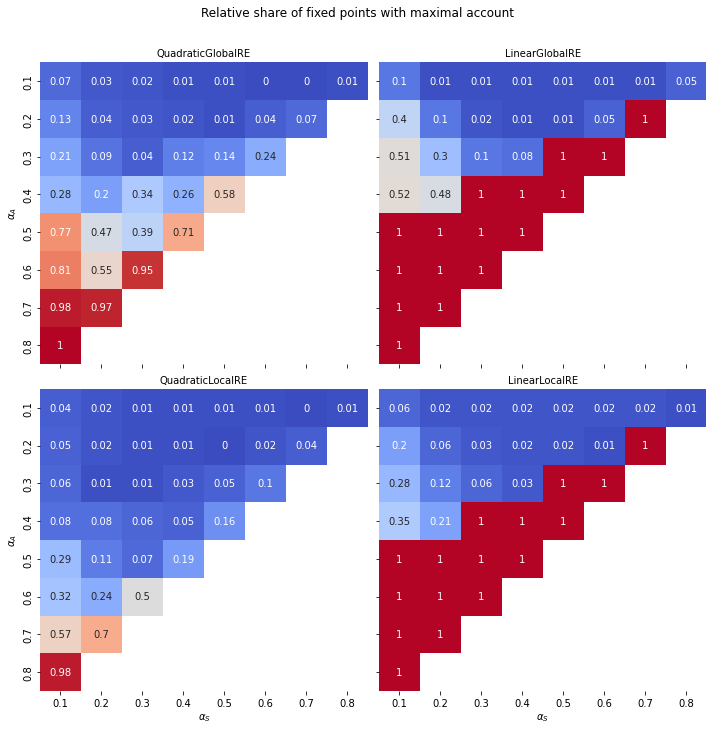

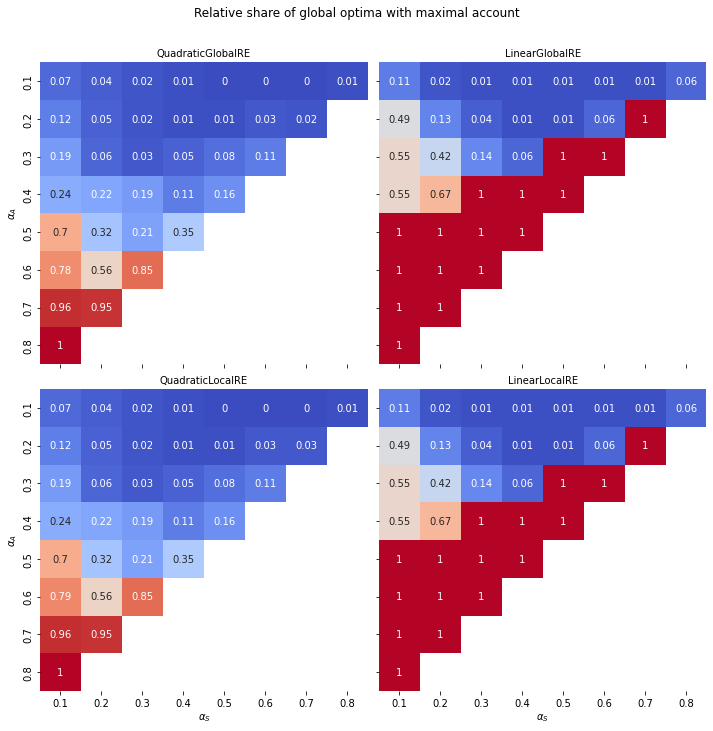

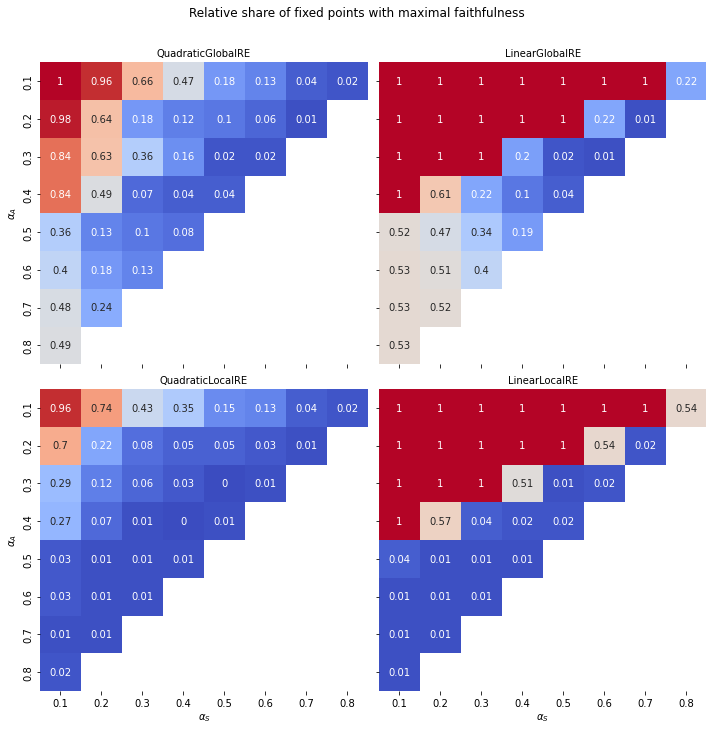

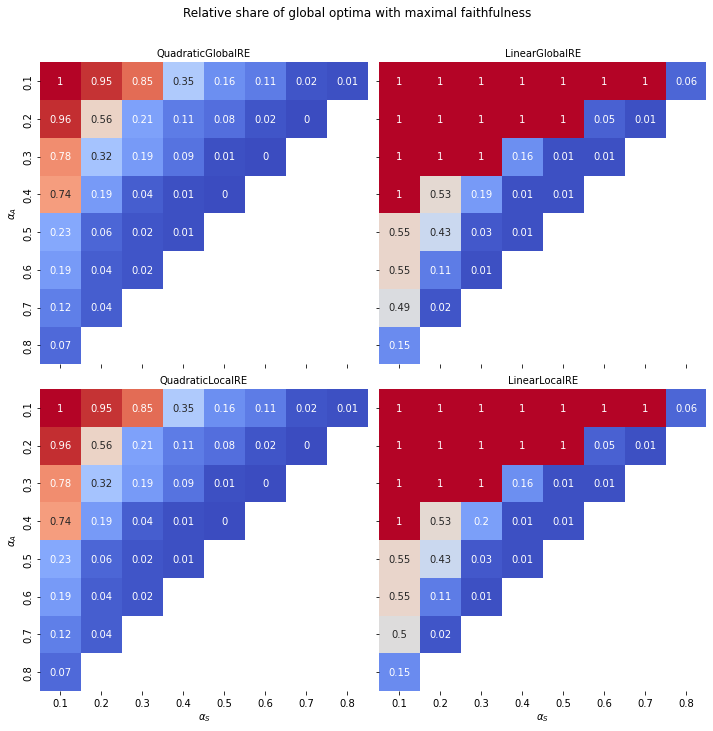

In [131]:
for measure, endpoint_type in product(["account", "faithfulness"], ["fp", "go"]):
    
    df = wgo_df if endpoint_type == "go" else wfp_df
    endpoint = "global optima" if endpoint_type == "go" else "fixed points"

    normalized_heat_maps_by_weights(df, 
                                    "rel_{}_max_{}".format(endpoint_type, measure), 
                                    "Relative share of {} with maximal {}".format(endpoint, measure),
                                    annot_std = False,
                                    #annot_fmt="{:2.2f}\n"
                                   )

    branches = "branches" if analyse_branches else "setups"

    if export_results:
        plt.savefig(path.join(figures_output_dir, 'rel_{}_max_{}_{}.png'.format(endpoint_type, measure, branches)), bbox_inches='tight')